Test compositional lotka volterra algorithm on human gut time series (female test person).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import torch
from scipy.io import loadmat

# from scipy.special import logsumexp
# from scipy.stats import pearsonr
# from scipy.stats import norm

from compositional_lotka_volterra import *

# Import dataset

### Read data

In [2]:
# function to import the datafile and put it into the right format
def create_data():
    ts_all = []
    data_all = []
    names_all = []
    for vessel in np.arange(4):
        # path of data file
        filename_tmp = f"ts_Silverman_V{vessel+1}_Class_rel_count.csv"
        filepath_tmp = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/" + filename_tmp
        data = pd.read_csv(filepath_tmp, sep=",", header=0)
        names = list(data.columns)[1:]
        usol = data.to_numpy()
        ts = usol[:, 0]
        data_y = usol[:, 1:]
        ts_all.append(ts)
        data_all.append(data_y)
        names_all.append(names)
        print(f"shape of vessel V{vessel+1}", data_y.shape)
    # set dimensions of the dataset
    global n_samples, n_taxa
    n_samples, n_taxa = data_y.shape
    return ts_all, data_all, names_all

In [3]:
T, Y, Names = create_data()

shape of vessel V1 (131, 19)
shape of vessel V2 (131, 19)
shape of vessel V3 (131, 19)
shape of vessel V4 (131, 19)


### Adjust data

In [4]:
def adjust_concentrations(Y):
    con =  []
    for y in Y:
        con += y.sum(axis=1).tolist()
    con = np.array(con)
    C = 1 / np.mean(con)

    Y_adjusted = []
    for y in Y:
        Y_adjusted.append(C*y)

    return Y_adjusted

In [33]:
Y = adjust_concentrations(Y) 
P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

# P = [P[0]]

In [34]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

### Plot data

In [35]:
# vessel = 0

# # plot only one vessel
# fig, ax = plt.subplots()
# for i in np.arange(n_taxa):
#     ax.plot(T[0], P[0][:,i], label = f"x{i} ({Names[vessel][i]})")
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_title(f"Vessel {vessel+1}")
# plt.show()

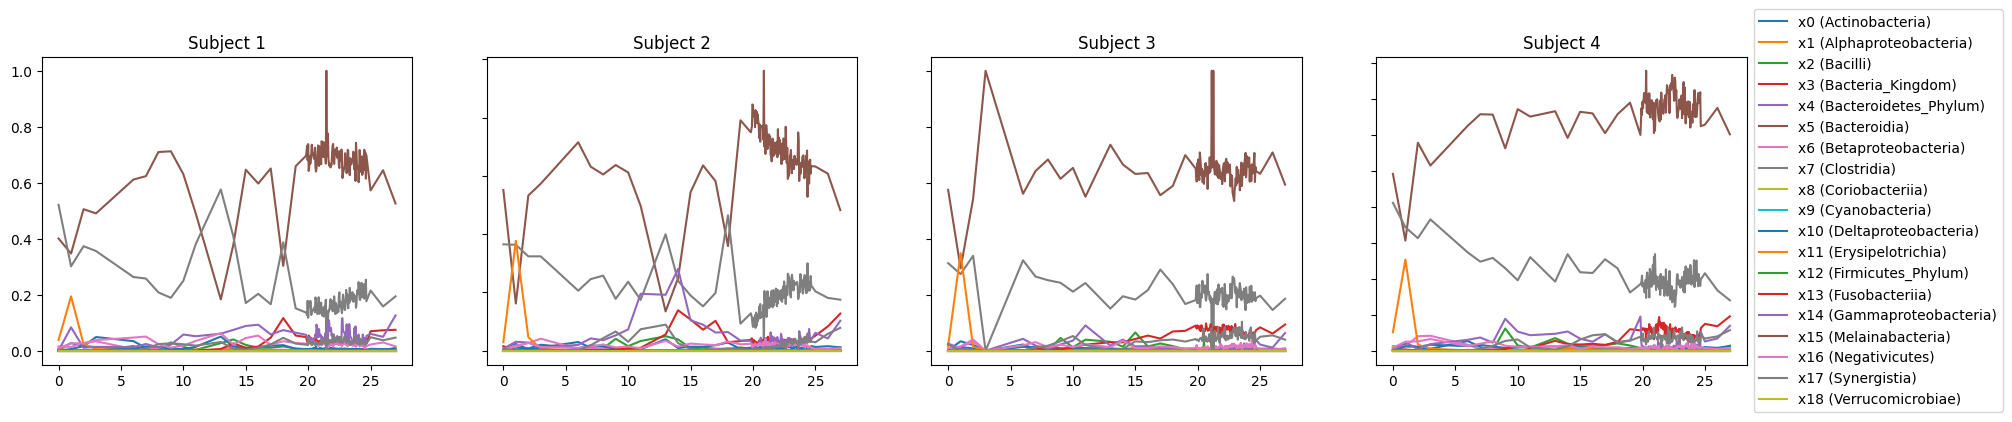

In [36]:
# plot time series with all taxa
fig, axs = plt.subplots(1, 4)
fig.set_figwidth(22)
fig.set_figheight(4)
for vessel in np.arange(4):
    for i in np.arange(n_taxa):
        axs[vessel].plot(T[vessel], P[vessel][:,i], label = f"x{i} ({Names[vessel][i]})")
    # ax[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[vessel].set_title(f"Subject {vessel+1}")

for ax in axs.flat:
    ax.label_outer()
    # ax.set_ylim(-0.01, 0.55)

axs[vessel].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [31]:
choose_denom(P)

1

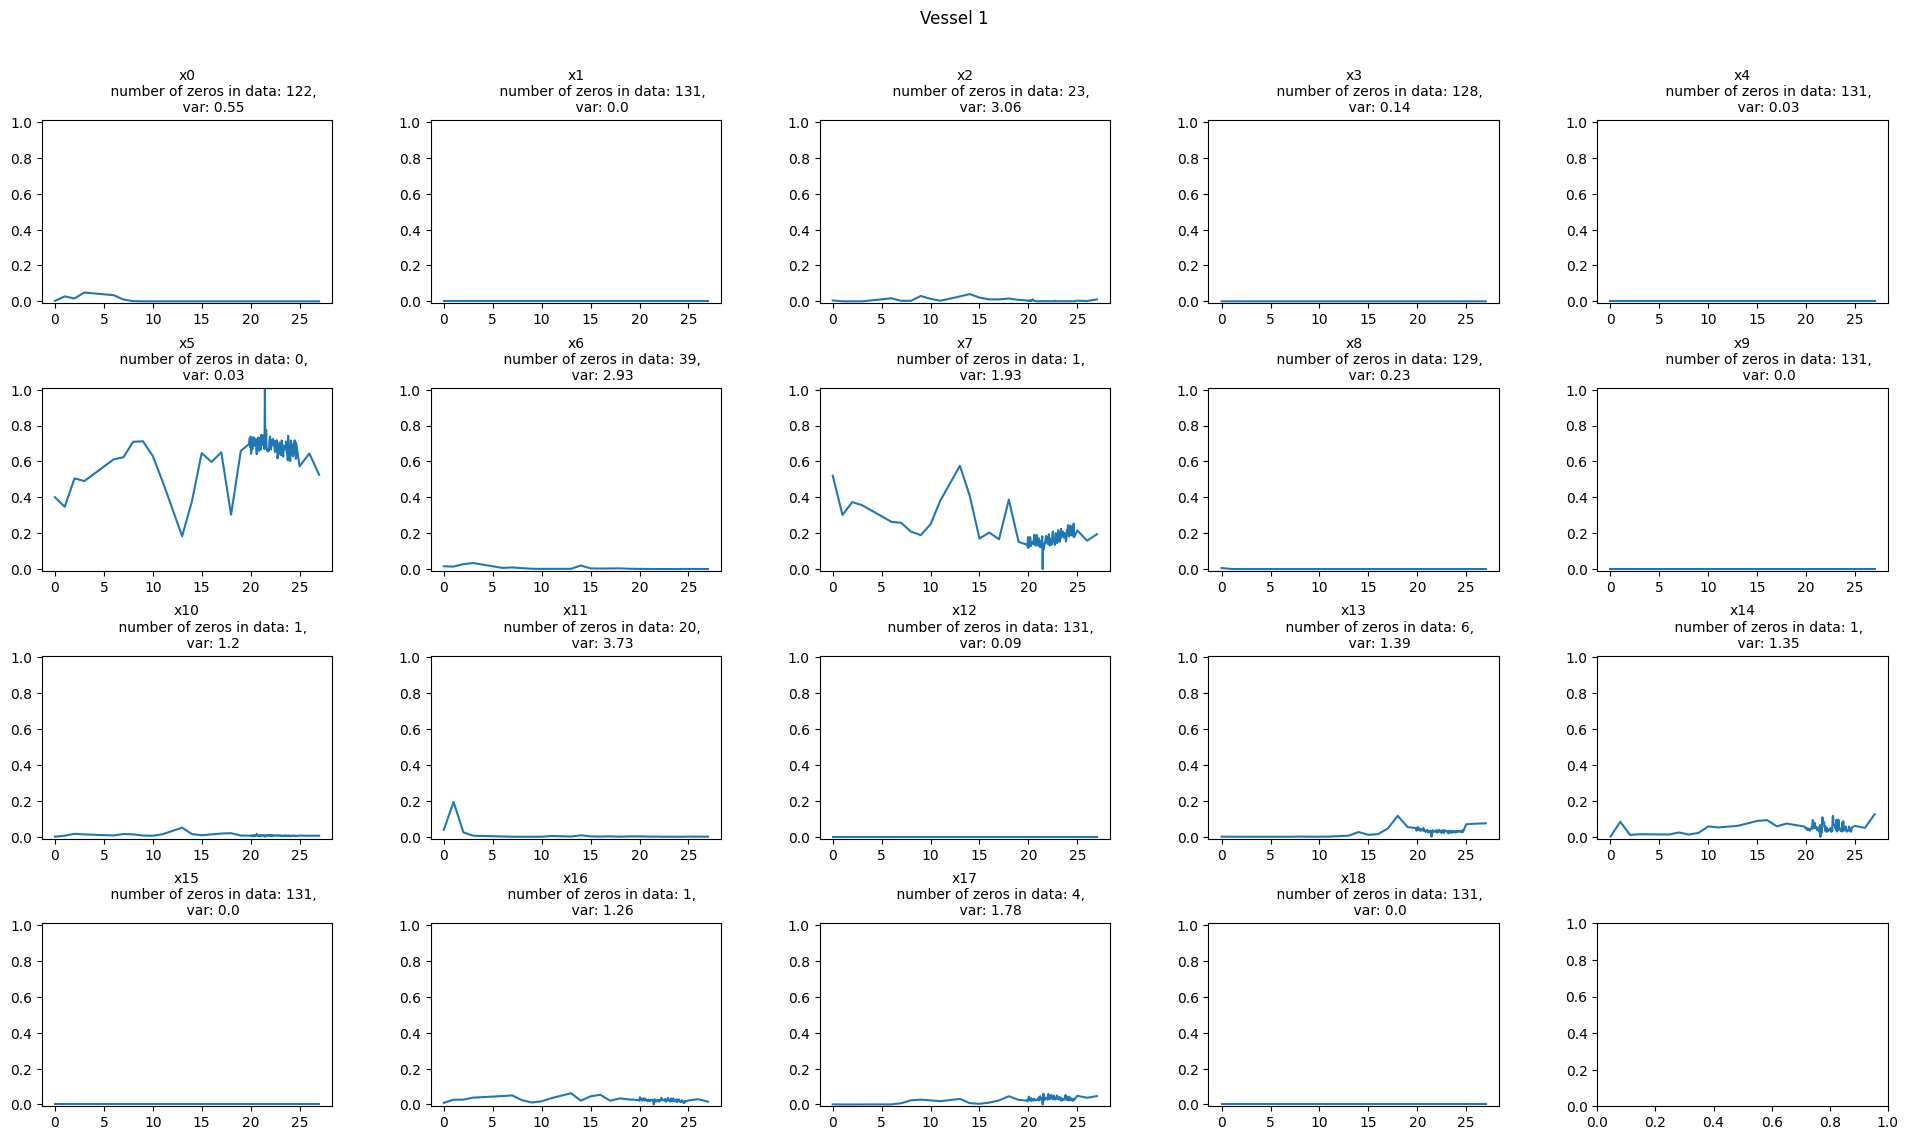

In [41]:
n_row = 4
n_col = 5
# plot time series with all otus
for vessel in np.arange(1):
    fig, axs = plt.subplots(n_row, n_col)
    fig.set_figwidth(20)
    fig.set_figheight(12)
    fig.suptitle(f"Vessel {vessel+1}")
    fig.tight_layout(pad=4.0)
    for i in np.arange(n_taxa):
        # plot each taxon timeline separately
        axs[math.floor(i/n_col), (i%n_col)].plot(T[vessel], P[vessel][:,i])
        axs[math.floor(i/n_col), (i%n_col)].set_title(f"""x{i}
            number of zeros in data: {sum(Y[vessel][:,i] == 0)},
            var: {round(vars[i],2)}""")
        axs[math.floor(i/n_col), (i%n_col)].title.set_size(10)
        axs[math.floor(i/n_col), (i%n_col)].set_ylim([-0.01, 1.01])

### Perform ALR transformation

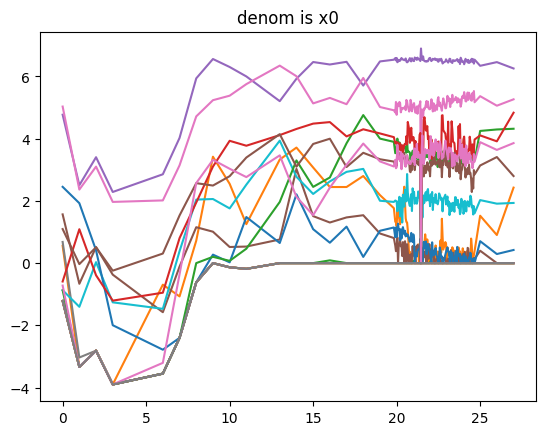

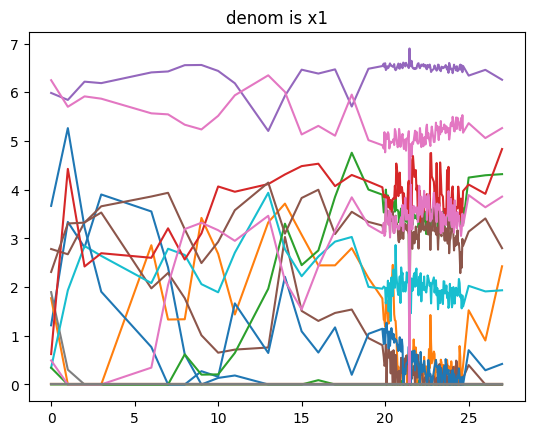

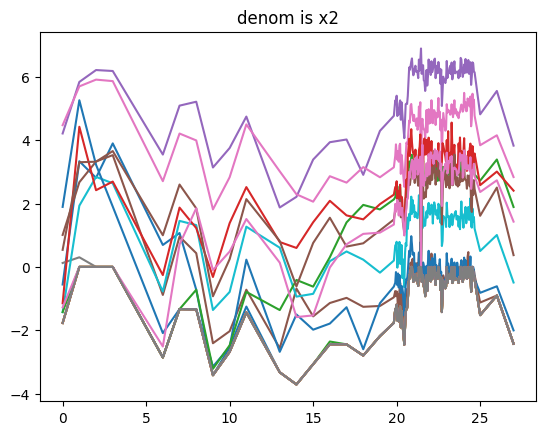

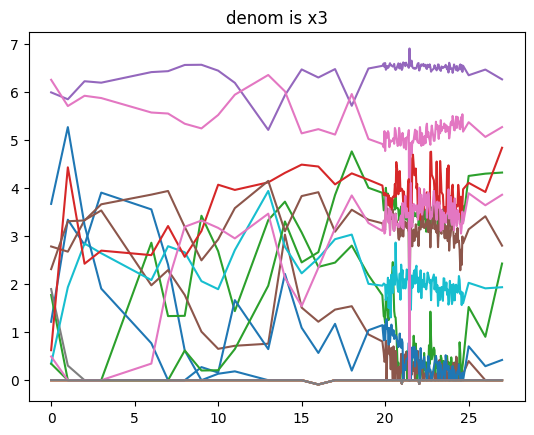

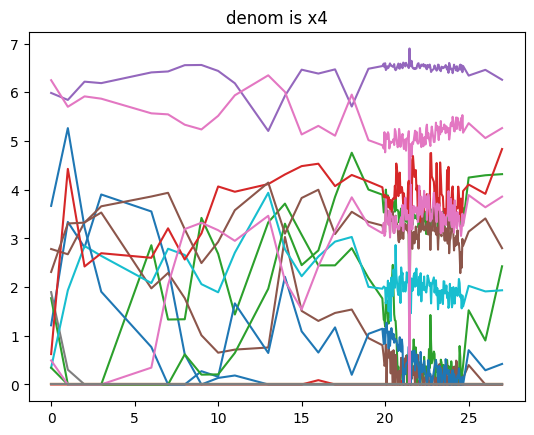

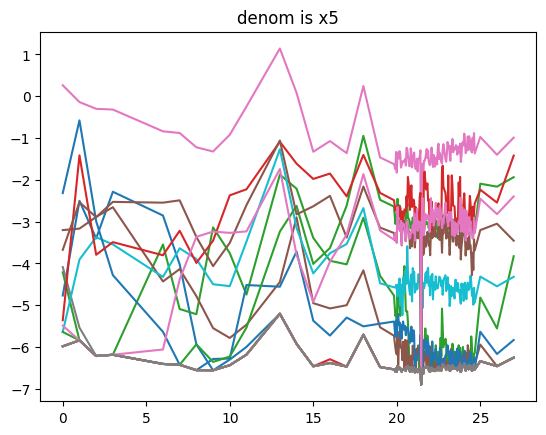

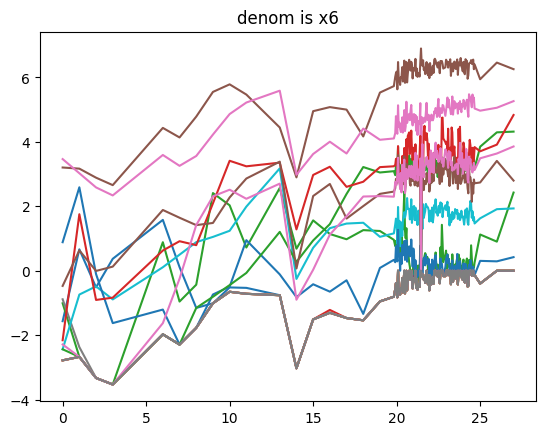

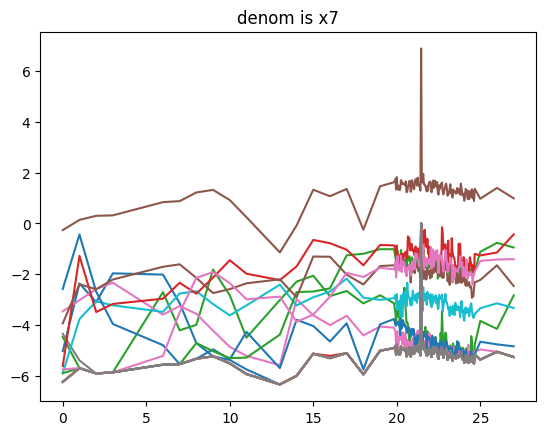

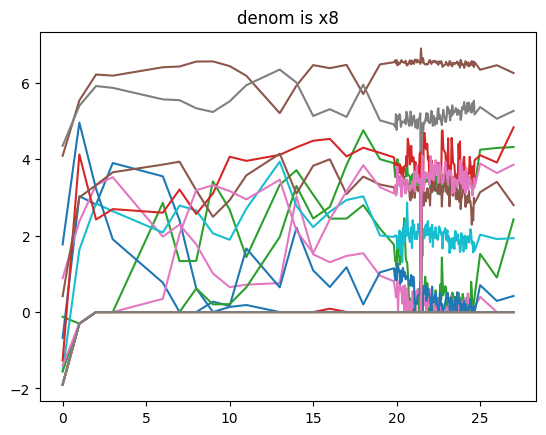

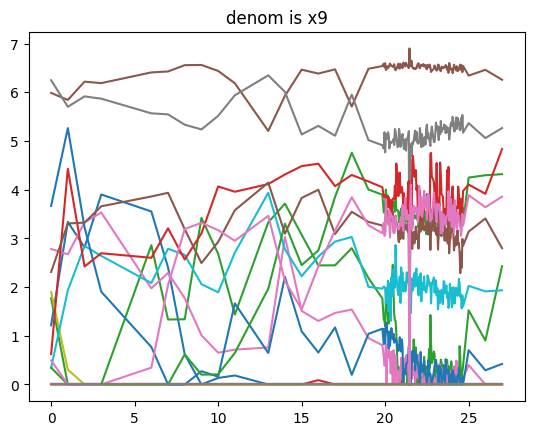

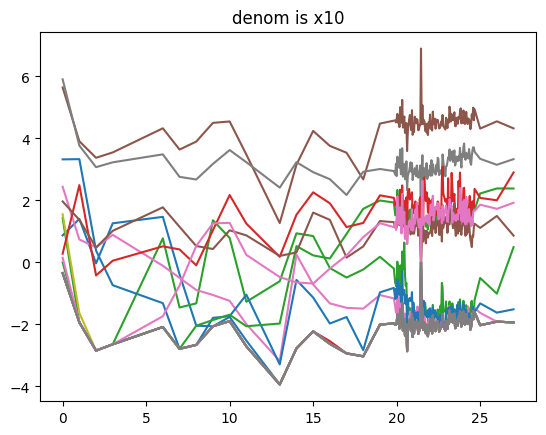

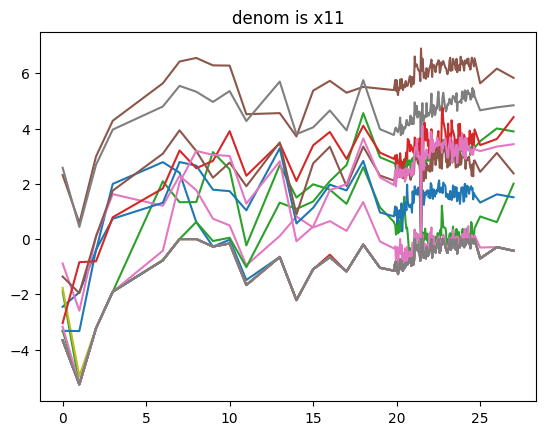

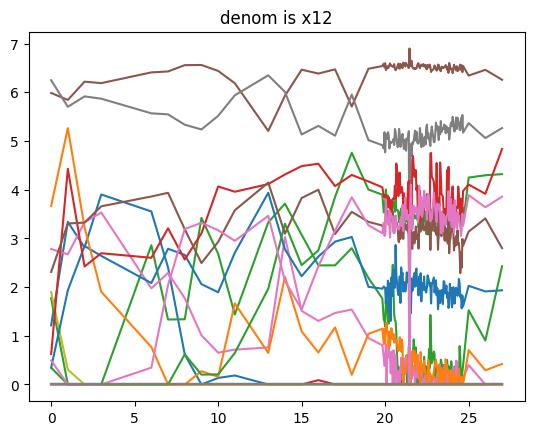

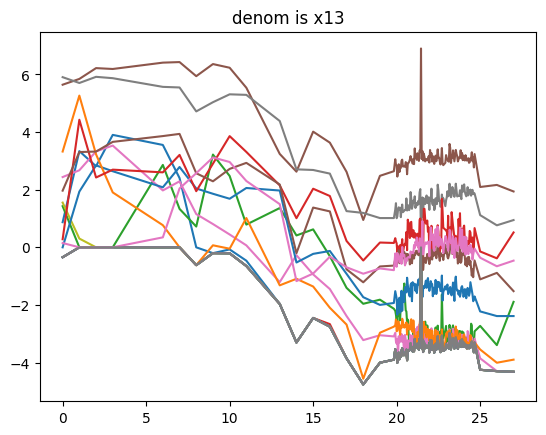

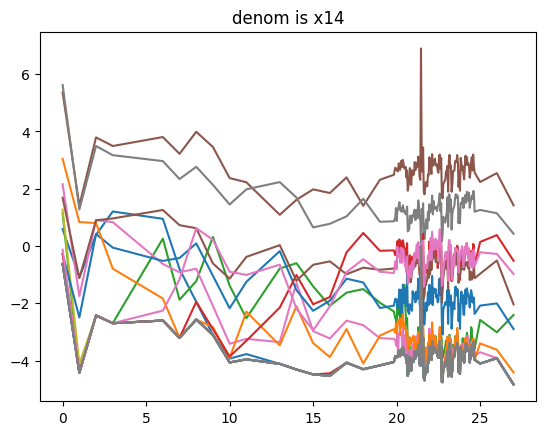

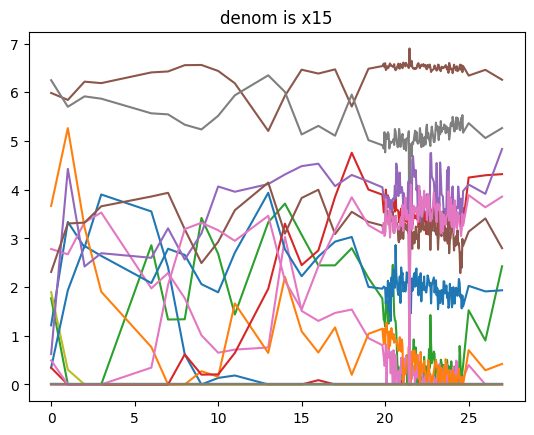

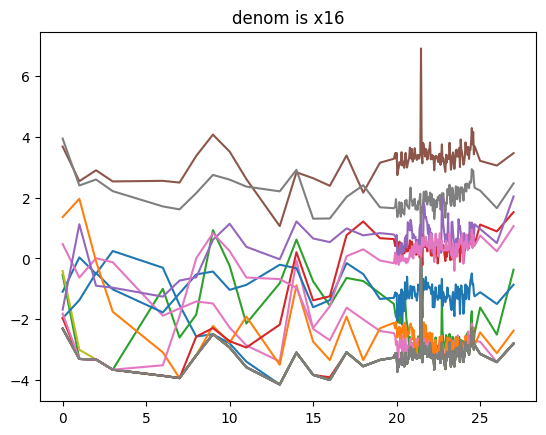

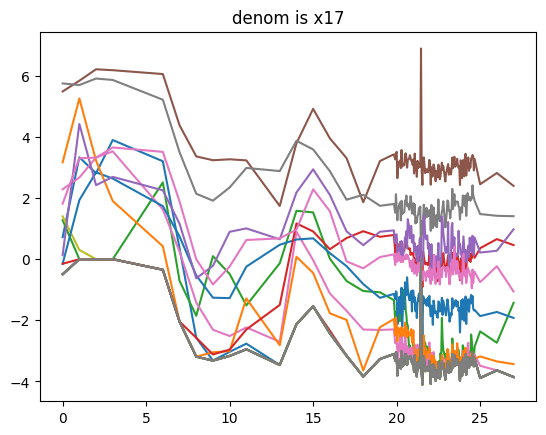

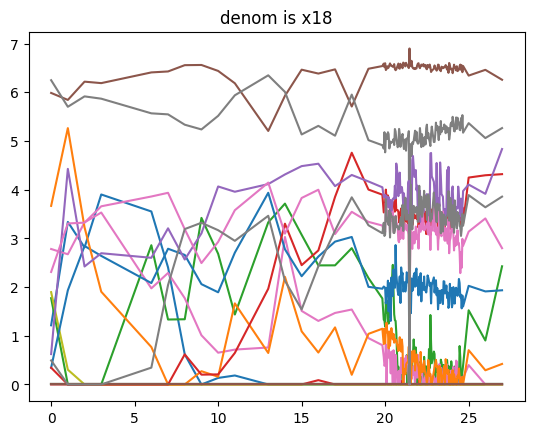

In [39]:
# plot data after alr for transformation with every otu as denominator
vessel = 0
for denom_tmp in np.arange(n_taxa):
    ALR_tmp = construct_alr(P, denom_tmp)
    # plot alr
    fig, ax = plt.subplots()
    for i in np.arange(n_taxa-1):
        ax.plot(T[vessel], ALR_tmp[vessel][:,i]) #, label = f"x{i+1}"
    # ax.plot(T[0], Y[0][:, denom_tmp], color='black', linewidth=2)
    # ax.legend()
    ax.set_title(f"denom is x{denom_tmp}")

In [8]:
# use choose_denom function to select denominator
denom = choose_denom(P)
# denom = 5
print(denom)

ALR = construct_alr(P, denom)

1


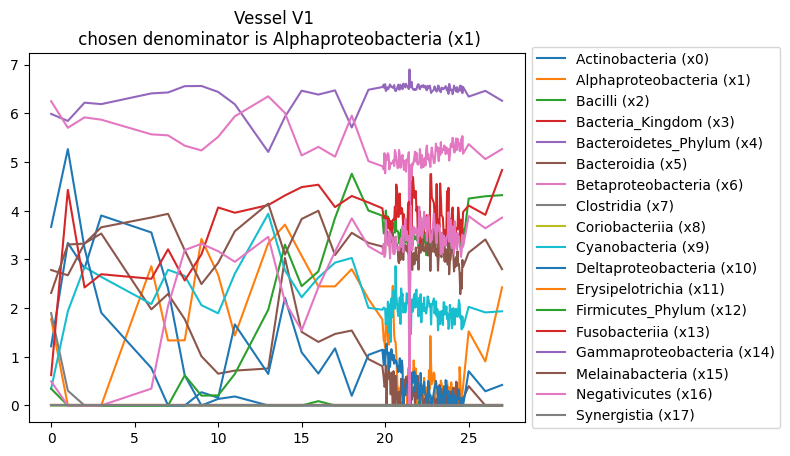

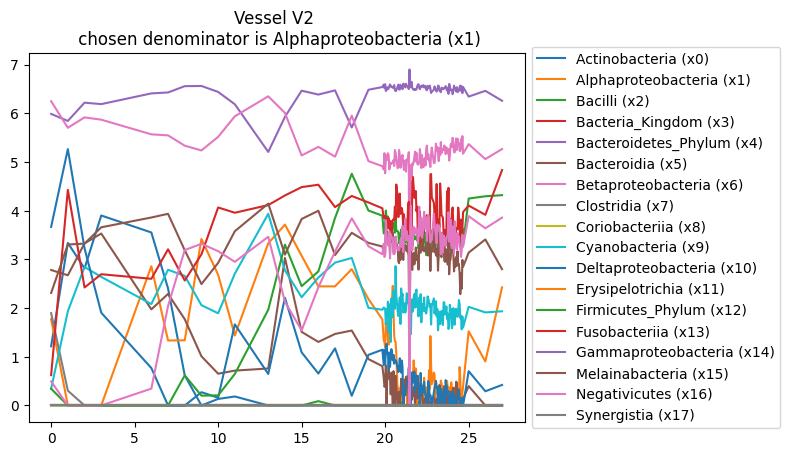

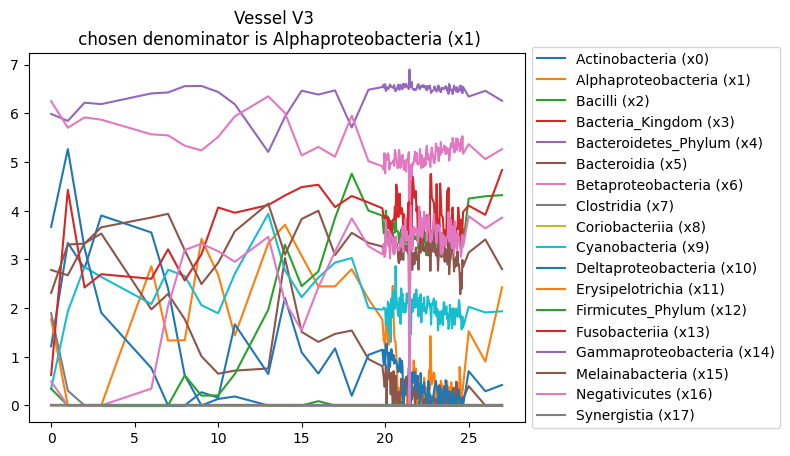

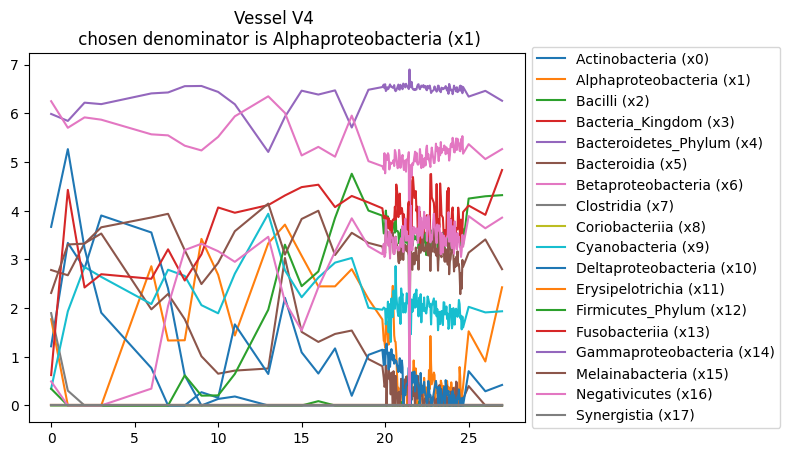

In [9]:
# plot alr
for vessel in np.arange(4):
    fig, ax = plt.subplots()
    for i in np.arange(n_taxa-1):
        ax.plot(T[0], ALR[0][:,i], label = f"{Names[vessel][i]} (x{i})")
    ax.set_title(f"Vessel V{vessel+1} \n chosen denominator is {Names[vessel][denom]} (x{denom})")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Compositional Lotka Volterra

In [10]:
U = [ np.zeros((x.shape[0], 1)) for x in P ]
estimate_elastic_net_regularizers_cv(X = ALR, P=P, U=U, T = T, denom = denom, folds = 10)

	r (0.1, 0.1, 0.1, 0.1) sqr error 0.6160225284183574
	r (0.1, 0.1, 0.1, 0.5) sqr error 0


(0.1, 0.1, 0.1, 0.5)

In [11]:
clv = CompositionalLotkaVolterra(P, T, denom = 5, pseudo_count=1e-5)
# clv = CompositionalLotkaVolterra(P, T, pseudo_count=1e-5)

In [12]:
clv.alpha = 1
clv.r_A = 0.25
clv.r_g = 4
clv.r_B = 0.125

In [13]:
clv.train()

In [14]:
A_clv, g_clv, B_clv = clv.get_params()

In [15]:
# print(A_clv, g_clv, B_clv)
print(g_clv)

[ -2.43034552  -2.24450024 -20.99868749  -3.4296751   -2.28361288
 -16.32168394 -26.97768355  -2.60810013  -2.24450024 -20.67165863
 -14.75396696  -2.20684853 -24.78876886 -25.69496886  -2.24450024
 -24.34954361 -31.23671025  -2.24450024]
